In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
pd.set_option('display.max_columns', None)

In [12]:
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0

### Classification

In [13]:
task = "classification" 
datasets = ['openml_361063', 'openml_361069', 'openml_361062', 'openml_9978', 'openml_361071', 'openml_43']
split_seeds = [1,2,3]
sample_seeds = [1,2,3,4,5]
combined_df = pd.DataFrame()
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}_stability/{data}_stability/varying_sample_row_n"
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [14]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF'
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_43": "Spam",
    "openml_361062": "Pol",
    "openml_361071": "Jannis",
    "openml_9978": "Ozone",
    "openml_361069": "Higgs",
    "openml_361063": "House 16H"
}

feature_values = {
    "openml_43": 57,
    "openml_361062": 26,
    "openml_361071": 54,
    "openml_9978": 47,
    "openml_361069": 24,
    "openml_361063": 16
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA'
}

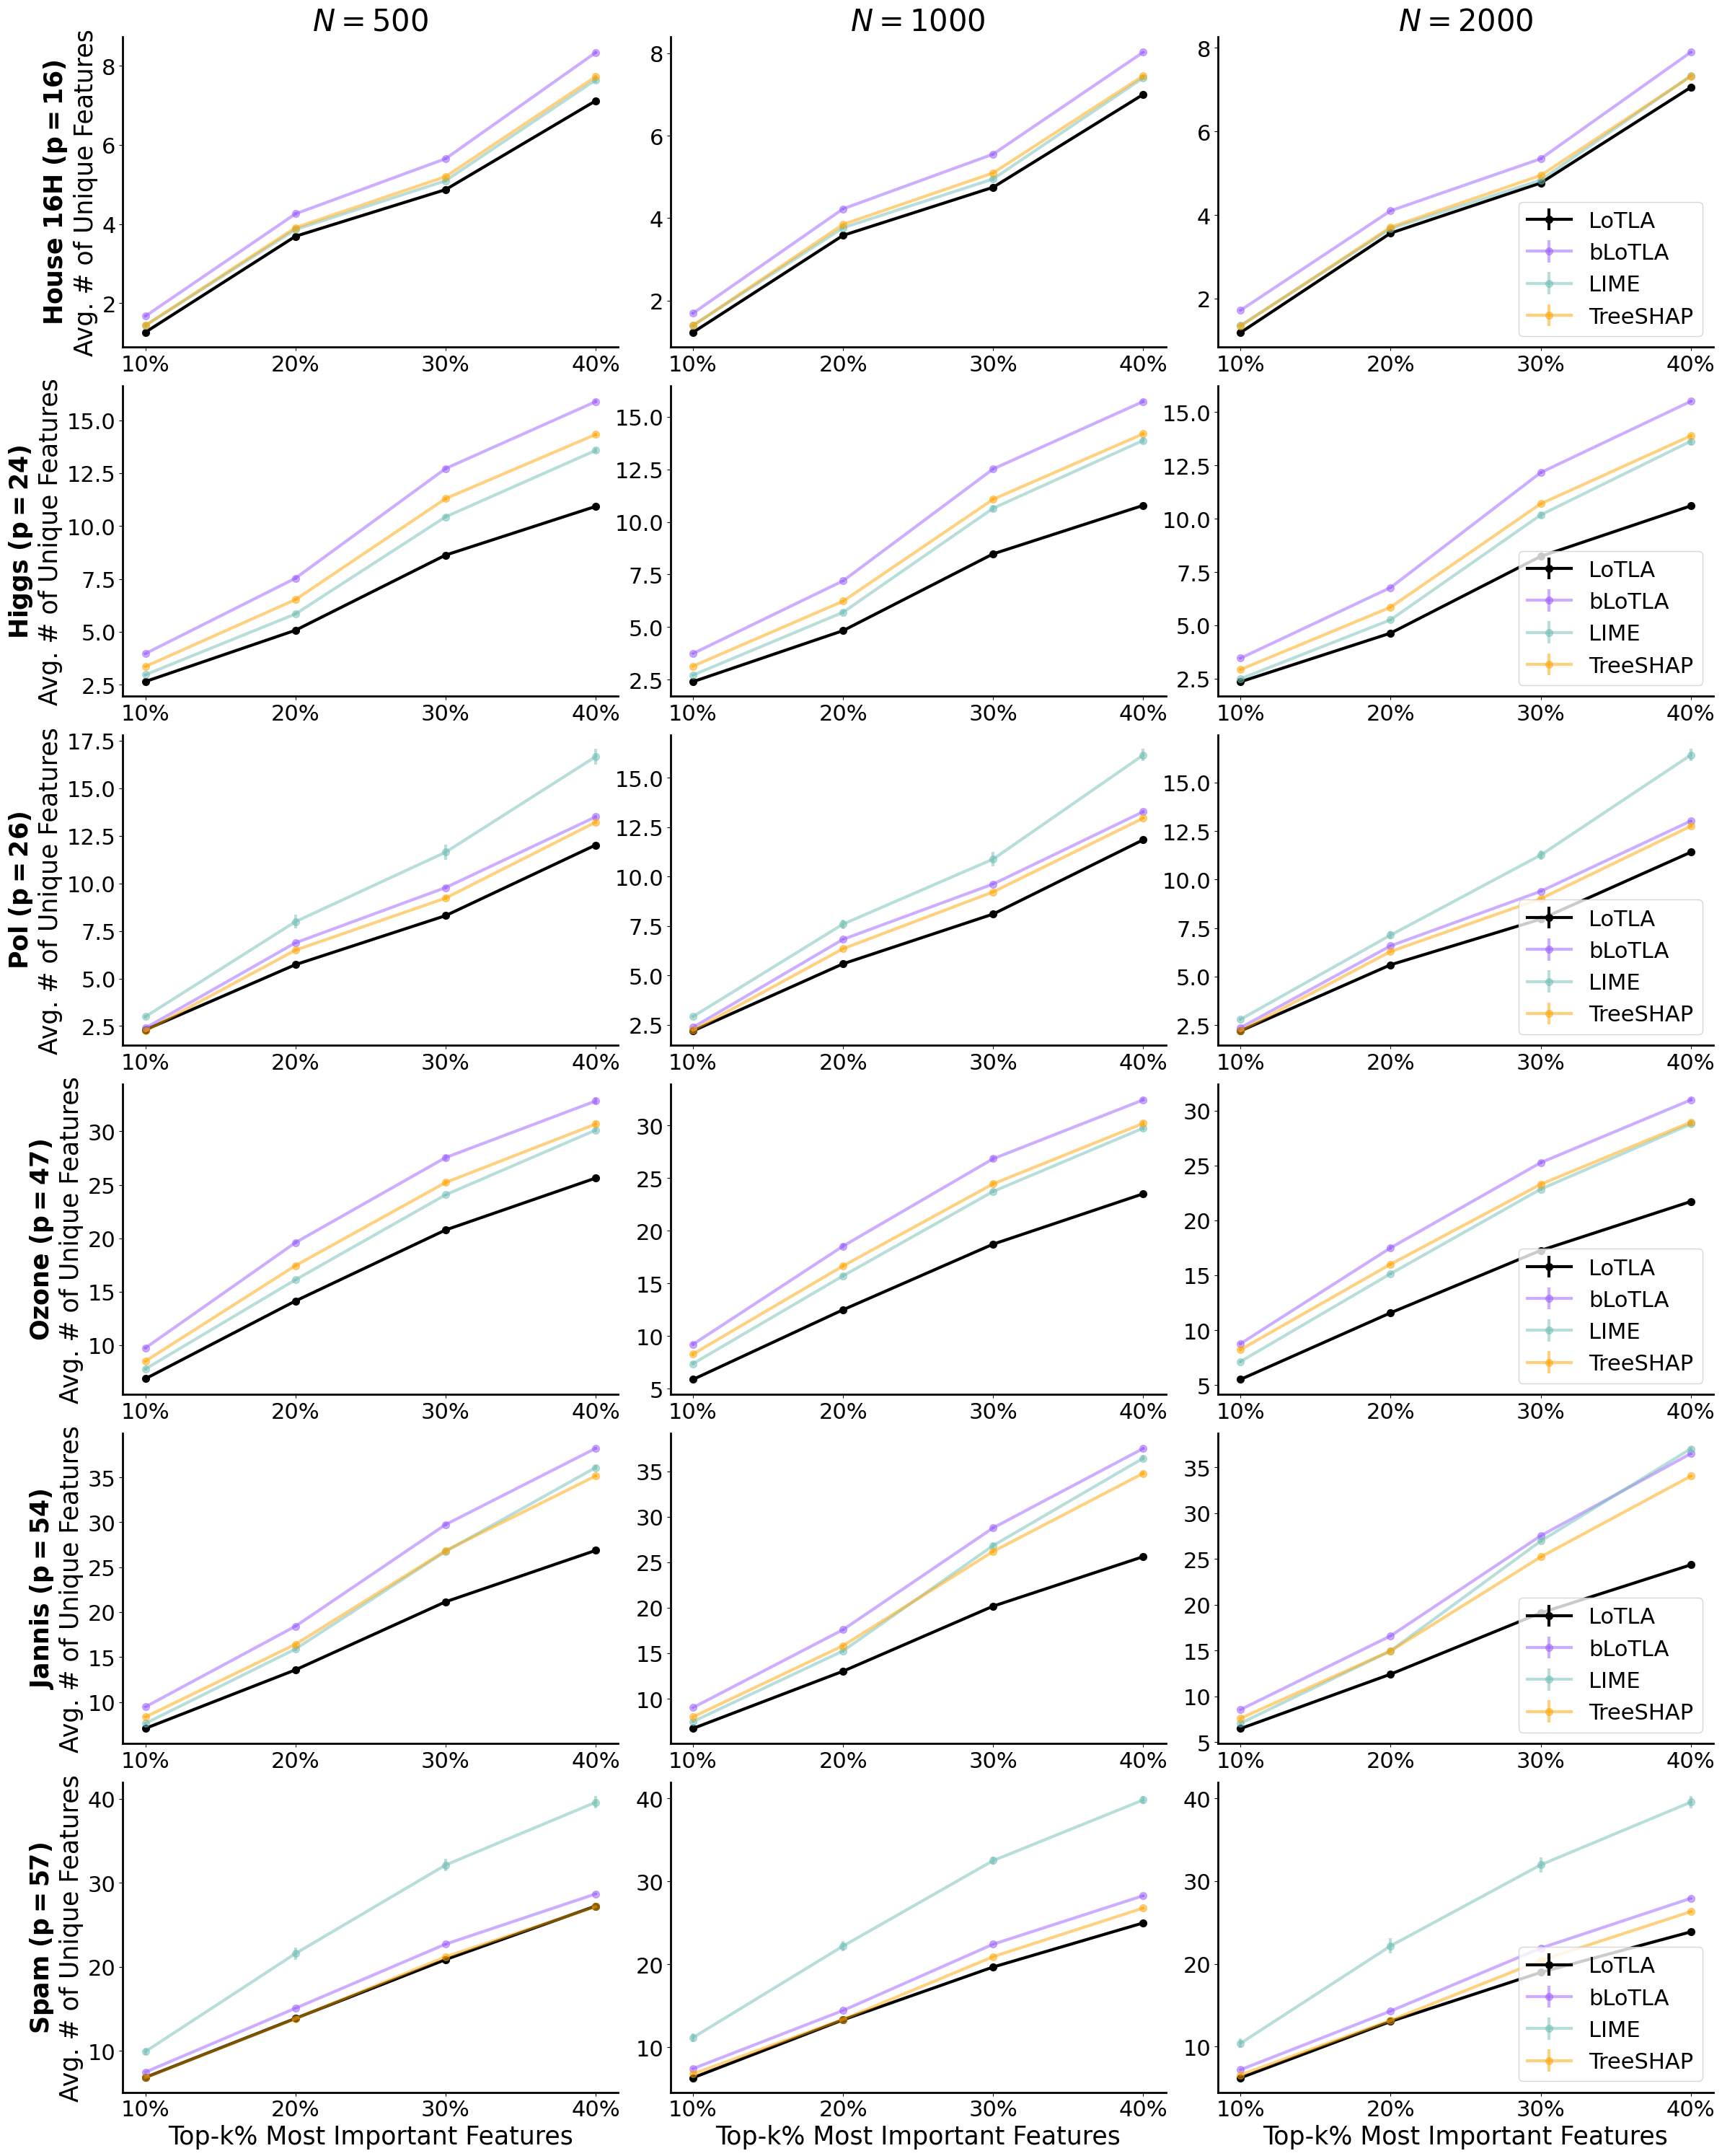

In [15]:
df = combined_df
datasets = df["data"].unique()
sample_size_all = df["sample_row_n"].unique()
marker_size = 7

n_cols = len(sample_size_all)
n_rows = len(datasets)

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False
)

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

for row_idx, dataset in enumerate(datasets):
    for col_idx, sample_size in enumerate(sample_size_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["sample_row_n"] == sample_size)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]

            x = [0.1, 0.2, 0.3, 0.4]
            cols = ["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]
            means = method_data[cols].mean(axis=0).values
            stds = method_data[cols].std(axis=0).values
            counts = method_data[cols].count(axis=0).values
            sems = stds / np.sqrt(counts)

            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.errorbar(
                    x, means, sems,
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.errorbar(
                    x, means, sems,
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
        ax.tick_params(axis='y', labelsize=22)
        if row_idx == n_rows - 1:
            ax.set_xlabel("Top-k% Most Important Features", fontsize=25)
        
        if col_idx == 0:
            dataset_label = data_name[dataset]
            p_val = feature_values[dataset]
            dataset_label = dataset_label.replace(' ', r'\ ')
            ax.set_ylabel(f"$\\mathbf{{{dataset_label}\ (p={p_val})}}$\nAvg. # of Unique Features", fontsize=25)
        else:
            ax.set_ylabel("")

        
        if row_idx == 0:
            ax.set_title(rf"$N = {sample_size}$", fontsize=30)

        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

plt.tight_layout(rect=[0.01, 0, 1, 1])
plt.savefig("stability_classification_full.png")
plt.show()

In [16]:
df_summary = df.groupby(['fi', 'data'])[["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]].mean().reset_index()
df_summary = df_summary[(df_summary["fi"] != "MDI+") & (df_summary["fi"] != "Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus") & (df_summary["fi"] != "Ablation_model2")]
columns_to_rank = ["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]

rank_results_classification = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=True, method='min')
    rank_results_classification = pd.concat([rank_results_classification, ranked_df], ignore_index=True)

#rename columns
rank_results_classification.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']
rank_results_classification.groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Ablation_model1,1.833333,1.500000,1.333333,1.000000
TreeSHAP_RF,2.333333,2.500000,2.333333,2.833333
LIME_RF,2.833333,2.833333,3.000000,3.500000
Ablation_model0,3.833333,3.666667,4.000000,3.333333
MDI,4.166667,4.500000,4.333333,4.333333


### Regression

In [17]:
task = "regression" 
combined_df = pd.DataFrame()
datasets = ['openml_361260', 'openml_361254', 'openml_361259', 'openml_361253', 'openml_361243', 'openml_361242']
for data in datasets:
    ablation_directory =f"/accounts/projects/binyu/zhongyuan_liang/local_MDI+/imodels-experiments/feature_importance/results/mdi_local.real_data_{task}_{data}_stability/{data}_stability/varying_sample_row_n"
    split_seeds = [1,2,3]
    sample_seeds = [1,2,3,4,5]
    for split_seed in split_seeds:
        for sample_seed in sample_seeds:
            df = pd.read_csv(os.path.join(ablation_directory, f"seed_{split_seed}_{sample_seed}/results.csv"))
            df["data"] = data
            combined_df = pd.concat([combined_df, df], ignore_index=True)

In [18]:
methods = [
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus',    
    'MDI',
    'LIME_RF',
    'TreeSHAP_RF'
]
color_map = {
    'LIME_RF': '#71BEB7',
    'TreeSHAP_RF': 'orange',
    'MDI': '#9B5DFF',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'black'
}

data_name = {
    "openml_361260": "Miami Housing",
    "openml_361259": "Puma Robot",
    "openml_361253": "Wave Energy",
    "openml_361254": "SARCOS",
    "openml_361242": "Super Conductivity",
    "openml_361243": "Geographic Origin of Music"
}


feature_values = {
    "openml_361260": 15,
    "openml_361259": 32,
    "openml_361253": 48,
    "openml_361254": 21,
    "openml_361242": 81,
    "openml_361243": 72
}

methods_name = {
    'LIME_RF': 'LIME',
    'MDI': 'bLoTLA',
    'TreeSHAP_RF': 'TreeSHAP',
    'Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus': 'LoTLA'
}

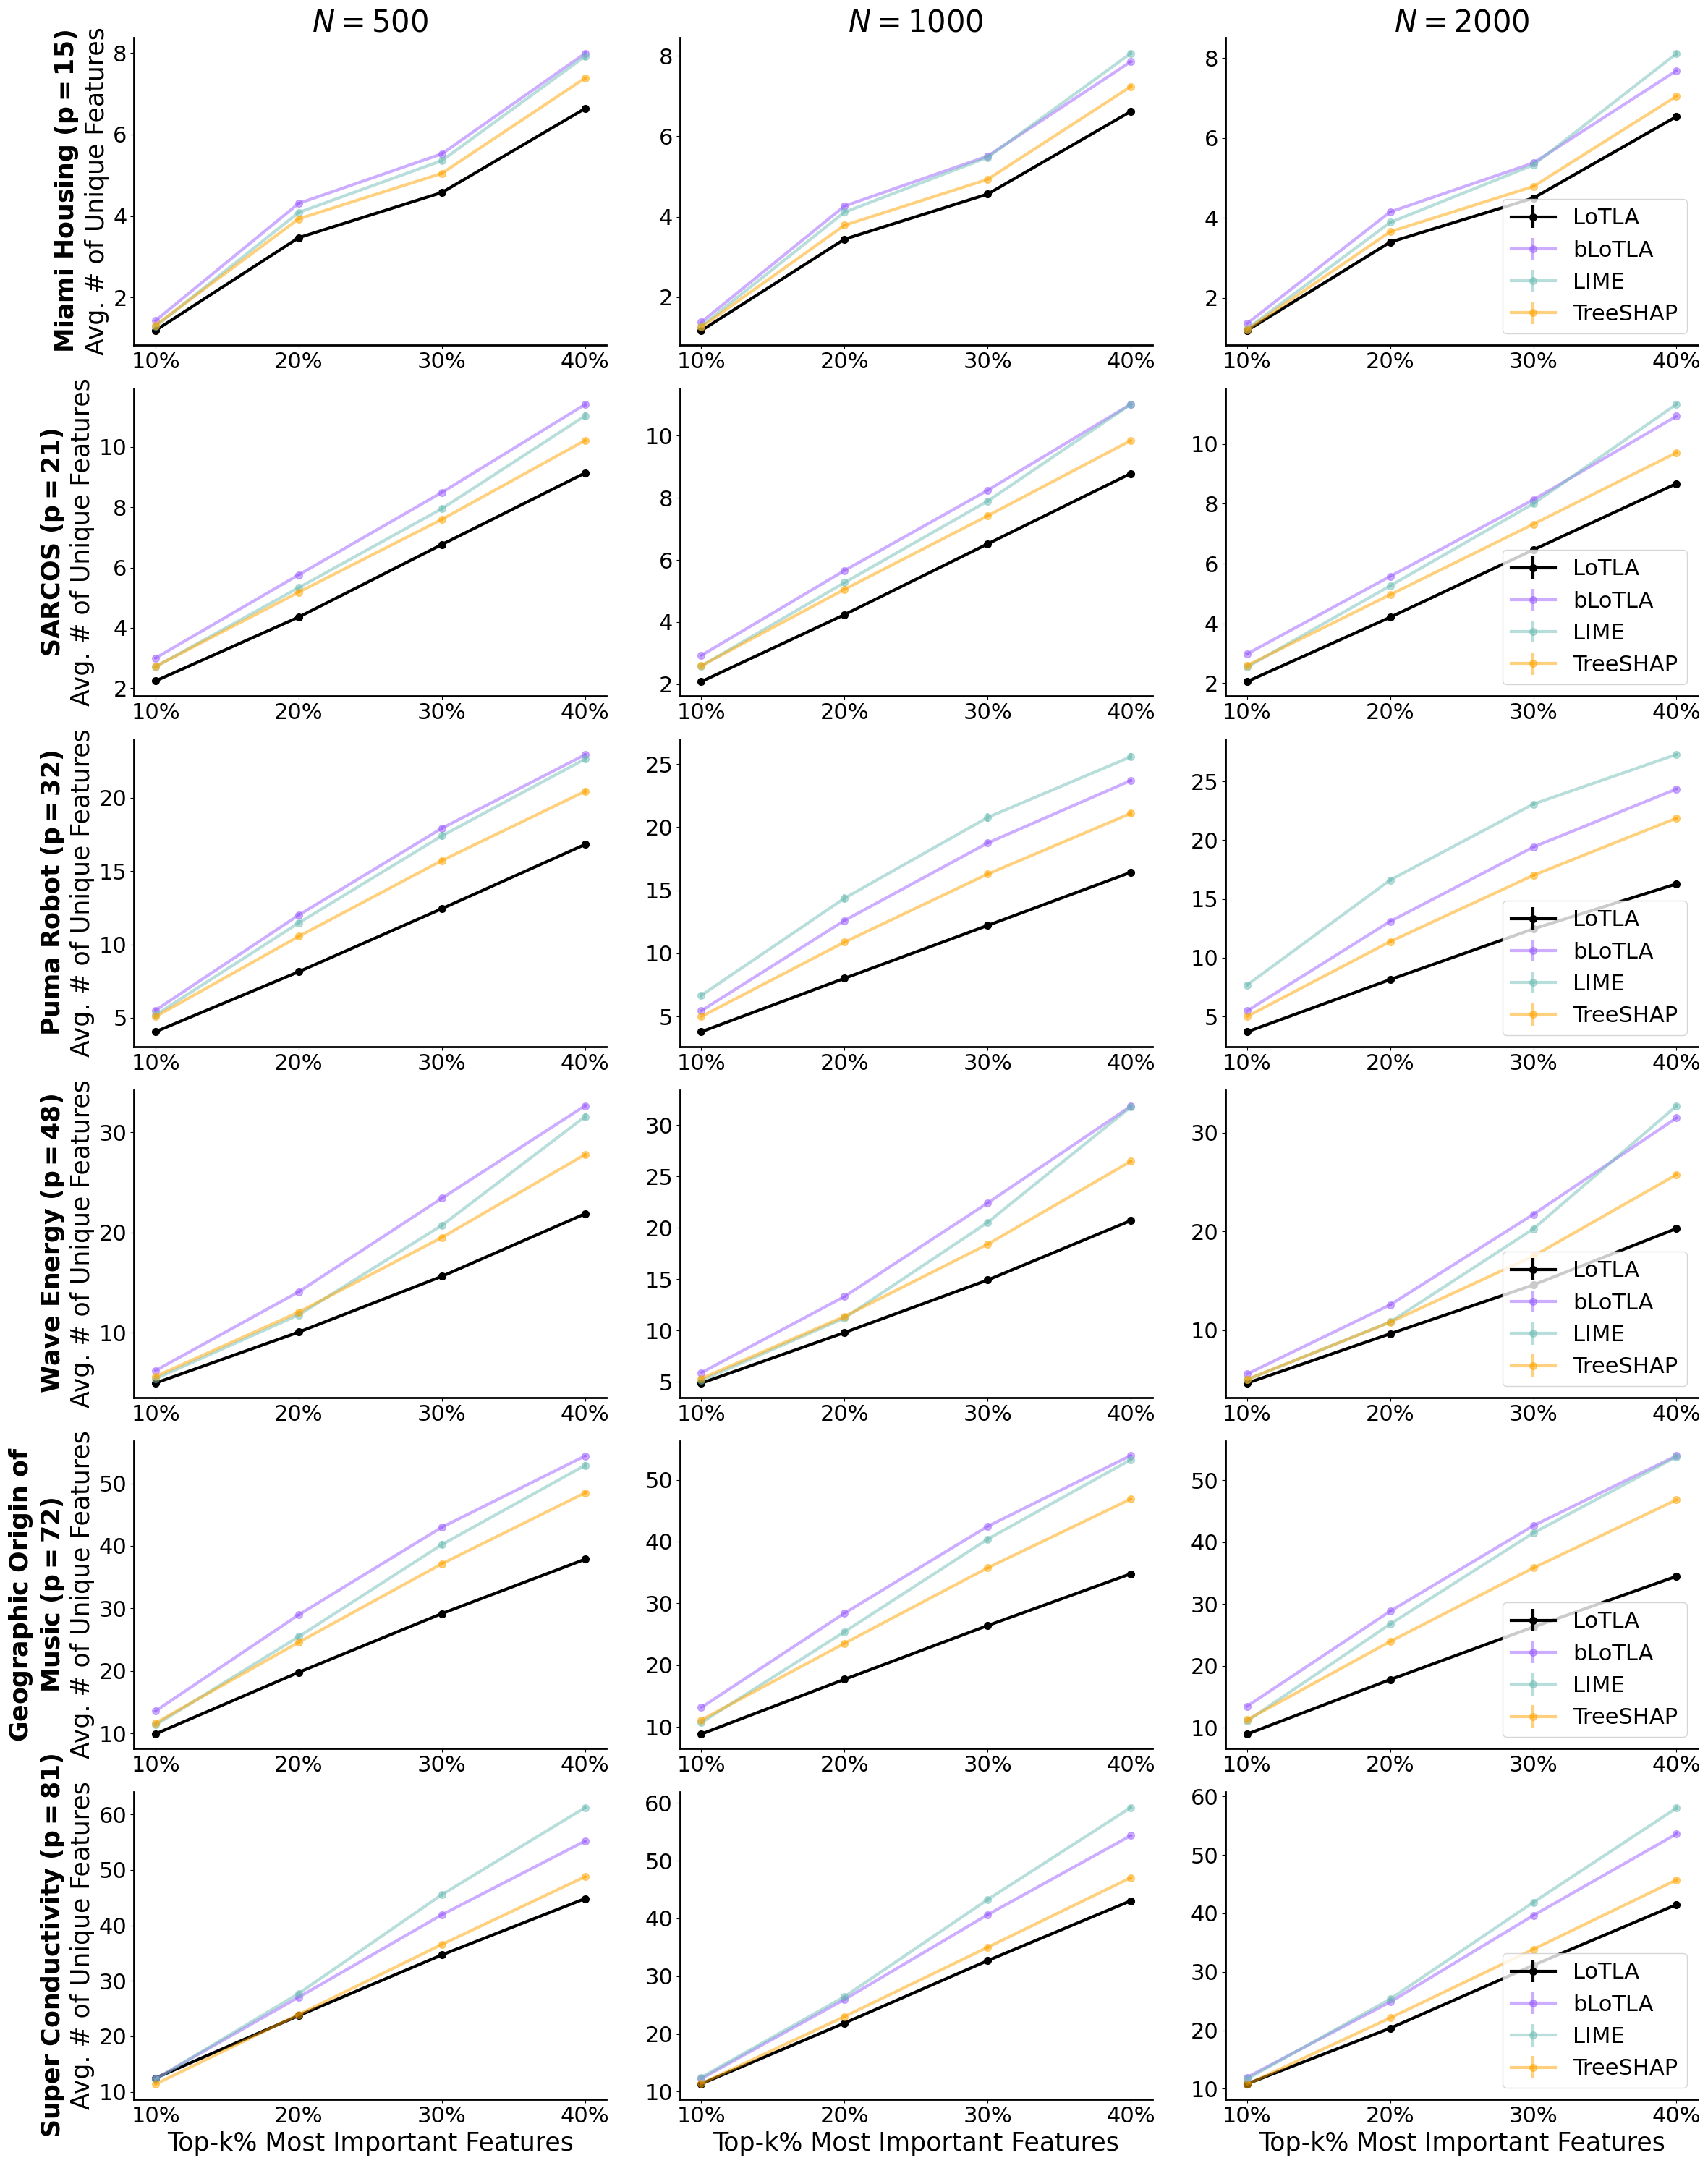

In [19]:
df = combined_df
datasets = df["data"].unique()
sample_size_all = df["sample_row_n"].unique()
marker_size = 7

n_cols = len(sample_size_all)
n_rows = len(datasets) 

fig, axs = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(8 * n_cols, 5 * n_rows),
    sharey=False 
)

if n_rows == 1:
    axs = np.expand_dims(axs, axis=0)
if n_cols == 1:
    axs = np.expand_dims(axs, axis=1)

for row_idx, dataset in enumerate(datasets):
    for col_idx, sample_size in enumerate(sample_size_all):
        ax = axs[row_idx, col_idx]
        subset = df[(df["data"] == dataset) & (df["sample_row_n"] == sample_size)]
        
        for method in methods:
            method_data = subset[subset["fi"] == method]

            x = [0.1, 0.2, 0.3, 0.4]
            cols = ["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]
            means = method_data[cols].mean(axis=0).values
            stds = method_data[cols].std(axis=0).values
            counts = method_data[cols].count(axis=0).values
            sems = stds / np.sqrt(counts)
            
            if method in ['LIME_RF', 'TreeSHAP_RF', 'MDI']:
                ax.errorbar(
                    x, means, sems,
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3, alpha=0.5
                )
            else:
                ax.errorbar(
                    x, means, sems,
                    linestyle='solid', marker='o', markersize=marker_size,
                    label=methods_name[method], color=color_map[method], linewidth=3
                )
        
        ax.set_xticks([0.1, 0.2, 0.3, 0.4])
        ax.set_xticklabels(["10%", "20%", "30%", "40%"], fontsize=22)
        ax.tick_params(axis='y', labelsize=22)
        if row_idx == n_rows - 1:
            ax.set_xlabel("Top-k% Most Important Features", fontsize=25)

        if col_idx == 0:
            dataset_label = data_name[dataset]
            p_val = feature_values[dataset]
            dataset_label = dataset_label.replace(' ', r'\ ')
            if dataset == "openml_361243":
                ax.set_ylabel(
                    f"$\\mathbf{{Geographic\ Origin\ of}}$\n$\\mathbf{{Music\ (p={p_val})}}$\nAvg. # of Unique Features",
                    fontsize=25
                )
            else:
                ax.set_ylabel(f"$\\mathbf{{{dataset_label} \ (p={p_val})}}$\nAvg. # of Unique Features", fontsize=25)
        else:
            ax.set_ylabel("")

        
        if row_idx == 0:
            ax.set_title(rf"$N = {sample_size}$", fontsize=30)

        if col_idx == n_cols - 1:
            ax.legend(fontsize=22, loc='lower right')

plt.tight_layout(rect=[0.01, 0, 1, 1])
plt.savefig("stability_regression_full.png")
plt.show()

In [20]:
df = combined_df
df_summary = df.groupby(['fi', 'data'])[["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]].mean().reset_index()
df_summary = df_summary[(df_summary["fi"] != "MDI+") & (df_summary["fi"] != "Ablation_model0") & (df_summary["fi"] != "Ablation_model1") & (df_summary["fi"] != "Ablation_model2")]
columns_to_rank = ["avg_10_features", "avg_20_features", "avg_30_features", "avg_40_features"]
rank_results_regression = pd.DataFrame()
for data in datasets:
    df_data = df_summary[df_summary["data"] == data]
    ranked_df = df_data.copy()
    for col in columns_to_rank:
        ranked_df[col] = df_data[col].rank(ascending=True, method='min')
    rank_results_regression = pd.concat([rank_results_regression, ranked_df], ignore_index=True)
rank_results_regression.columns = ['fi', 'data', 'top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']
rank_results_regression.groupby('fi')[['top_0.1', 'top_0.2', 'top_0.3', 'top_0.4']].mean().sort_values(by='top_0.1')

,top_0.1,top_0.2,top_0.3,top_0.4
fi,,,,
Local_MDI+_MDI_elasticnet_fit_on_all_ranking_RFPlus,1.166667,1.000000,1.000000,1.000000
TreeSHAP_RF,2.333333,2.166667,2.000000,2.000000
LIME_RF,2.666667,3.166667,3.333333,3.833333
MDI,3.833333,3.666667,3.666667,3.166667
